## Figure 5b and c
change low-pass filter cutoff frequency to see the results

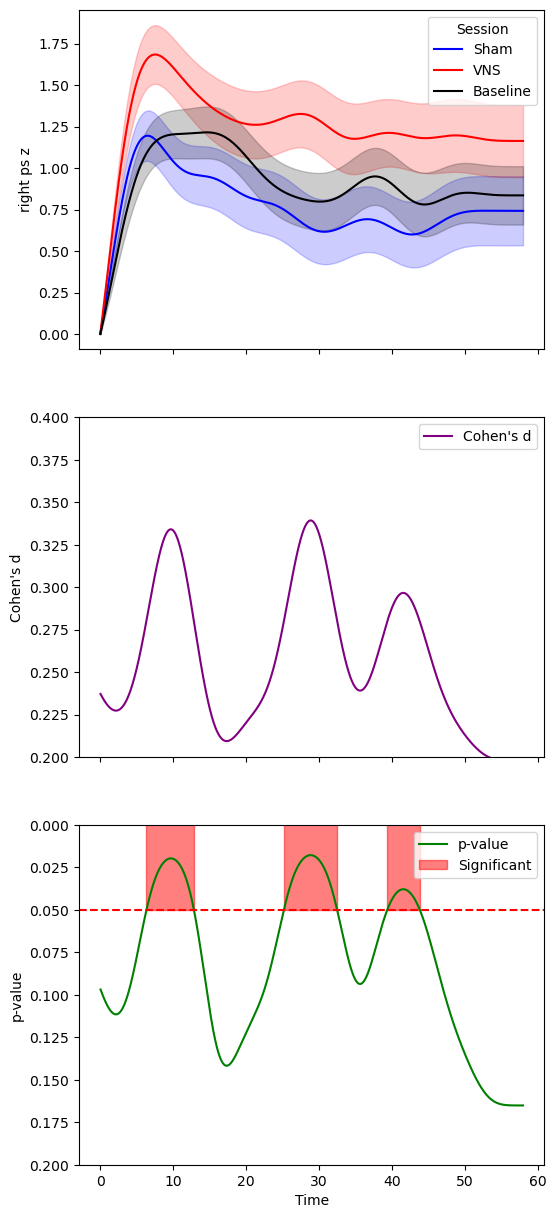

In [9]:
import os
import scipy
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
def butter_lowpass_filter(data, cutoff_freq, sampling_rate):
    b, a = butter(N=6, Wn=cutoff_freq/(0.5*sampling_rate), btype='low')
    return filtfilt(b, a, data)

def is_specific_event(value):
    return value in [1, 2, 3, 4, 5, 6, 7, 8, '1', '2', '3', '4']

palette = {'sham': 'b', 'VNS': 'r', 'baseline': 'black'}
filename = 'temporal_et_sum.mat'
mat_file = scipy.io.loadmat(filename)
temporal_et_mat = mat_file['temporal_et_struct']
temporal_et_list = []
fields_of_interest = ['subj_id', 'study_id', 'session', 'event', 'time', 'r_ps', 'r_ps_z', 'r_ps_0_1']

for i in range(temporal_et_mat.shape[1]):  
    element = temporal_et_mat[0, i]
    element_dict = {}
    for field in fields_of_interest:  # Iterate through each field
        if (field == 'event') & (len(np.shape(element['event'])) == 2):
            element_dict[field] = element[field][0][0]
        elif (field == 'r_ps') or (field == 'r_ps_z')  or (field == 'r_ps_0_1'):
            element_dict[field] = element[field][:, 0]
        else:
            element_dict[field] = element[field][0]
    temporal_et_list.append(element_dict) 

df_et = pd.DataFrame(temporal_et_list)

df_et_er = df_et[df_et['event'].apply(is_specific_event)]
metric_of_interest = 'r_ps_z'
time_start = 0
sfreq = 30
time_end = 58
num_points = (time_end - time_start) * sfreq   

ps_sham_list = []
ps_vns_list = []
ps_baseline_list = []


for index, row in df_et_er.iterrows():
    time_index = (row['time'] <= time_end) & (row['time'] >= time_start)
    ps2append = (row[metric_of_interest])[time_index]
    if np.all(np.isnan(ps2append)):
        continue
    ps2append = np.interp(np.arange(len(ps2append)), np.flatnonzero(~np.isnan(ps2append)), ps2append[~np.isnan(ps2append)])

    ps2append = butter_lowpass_filter(ps2append, cutoff_freq=0.1, sampling_rate=sfreq)  

    if row['session'] == 'sham':
        
        ps_sham_list.append(ps2append - ps2append[0])
    elif row['session'] == 'VNS':
        ps_vns_list.append(ps2append - ps2append[0])
    else:
        ps_baseline_list.append(ps2append - ps2append[0])
ps_baseline = np.array(ps_baseline_list)
ps_sham = np.array(ps_sham_list)
ps_vns = np.array(ps_vns_list)

mean_sham = np.nanmean(ps_sham, axis=0)
mean_vns = np.nanmean(ps_vns, axis=0)
mean_baseline = np.nanmean(ps_baseline, axis=0)

se_sham = np.nanstd(ps_sham, axis=0) / np.sqrt(np.count_nonzero(~np.isnan(ps_sham), axis=0))
se_vns = np.nanstd(ps_vns, axis=0) / np.sqrt(np.count_nonzero(~np.isnan(ps_vns), axis=0))
se_baseline = np.nanstd(ps_baseline, axis=0) / np.sqrt(np.count_nonzero(~np.isnan(ps_baseline), axis=0))

time_vector = np.linspace(time_start, time_end, num_points)
cohens_d = np.zeros_like(time_vector)
p_values = np.zeros_like(time_vector)

for i in range(len(time_vector)):
    data_vns = ps_vns[:, i]
    data_sham = ps_sham[:, i]
    
    data_vns = data_vns[~np.isnan(data_vns)]
    data_sham = data_sham[~np.isnan(data_sham)]
    
    if len(data_vns) < 2 or len(data_sham) < 2:
        cohens_d[i] = np.nan
        p_values[i] = np.nan
        continue
    
    var_vns = np.var(data_vns)
    var_sham = np.var(data_sham)

    if var_vns == 0 or var_sham == 0:
        cohens_d[i] = np.nan
    else:
        # Calculate Cohen's d
        cohens_d[i] = (np.mean(data_vns) - np.mean(data_sham)) / np.sqrt((var_vns + var_sham) / 2)
    t_stat, p_values[i] = stats.ttest_ind(data_vns, data_sham, equal_var=False, nan_policy='omit')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=[6, 15])

ax1.plot(time_vector, mean_sham, label='Sham', color='b')
ax1.fill_between(time_vector, mean_sham - se_sham, mean_sham + se_sham, color='b', alpha=0.2)
ax1.plot(time_vector, mean_vns, label='VNS', color='r')
ax1.fill_between(time_vector, mean_vns - se_vns, mean_vns + se_vns, color='r', alpha=0.2)
ax1.plot(time_vector, mean_baseline, label='Baseline', color='black')
ax1.fill_between(time_vector, mean_baseline - se_baseline, mean_baseline + se_baseline, color='black', alpha=0.2)
ax1.set_ylabel('right ps z')
ax1.legend(title='Session')

# Plotting Cohen's d
ax2.plot(time_vector, cohens_d, label='Cohen\'s d', color='purple')
ax2.set_ylabel('Cohen\'s d')
ax2.set_ylim([0.2, 0.4])
ax2.legend()

# Plotting p-values
ax3.plot(time_vector, p_values, label='p-value', color='green')
ax3.fill_between(time_vector, -0.05, 0.05, where=(np.array(p_values) < 0.05), color='r', alpha=0.5, label='Significant')
ax3.axhline(0.05, color='r', linestyle='--')  
ax3.set_ylabel('p-value')
ax3.legend()


# X-axis label
ax3.set_xlabel('Time')
ax3.set_ylim([0, 0.2])
ax3.invert_yaxis() 

plt.show()

## Figure 5d

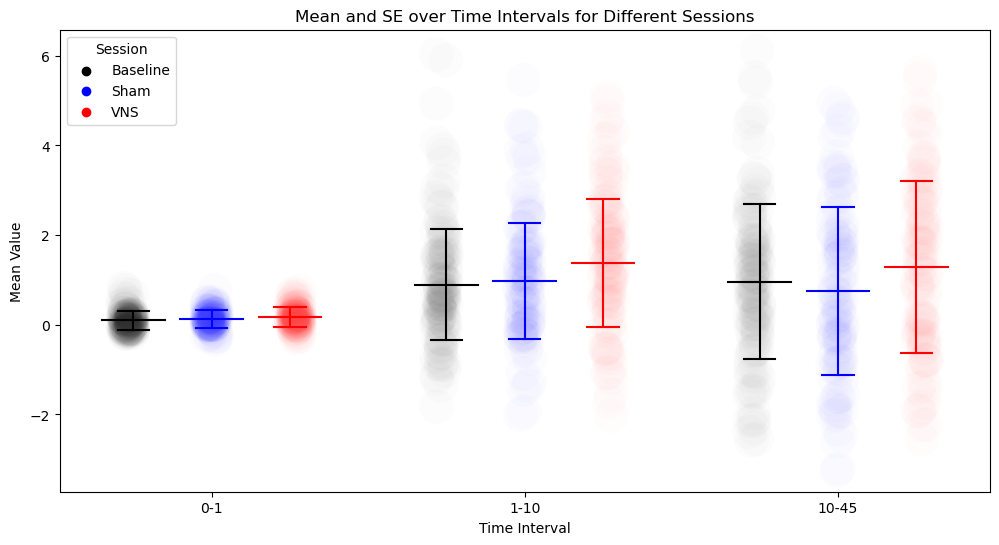

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
time_intervals = [(0, 1), (1, 10), (10, 45)]

# Function to label time intervals
def label_interval(time, intervals):
    for start, end in intervals:
        if start <= time <= end:
            return f"{start}-{end}"
    return "N/A"

df_time_interval_list = []

for session, data_matrix in zip(['Sham', 'VNS', 'Baseline'], [ps_sham, ps_vns, ps_baseline]):
    for i in range(data_matrix.shape[0]):
        
        for start, end in time_intervals:  

            indices = np.where((time_vector >= start) & (time_vector <= end))[0]
  
            if len(indices) == 0:
                continue

            segment = data_matrix[i, indices]
            
            segment_mean = np.nanmean(segment)
            segment_median = np.median(segment)
            
            row = {'Time Start': start, 'Time End': end, 'Time Interval': f"{start}-{end}", 'Session': session, 
                   'r_ps_z_mean': segment_mean, 'r_ps_z_median': segment_median}
            df_time_interval_list.append(row)

df_time_interval = pd.DataFrame(df_time_interval_list)

order = ['Baseline', 'Sham', 'VNS']
palette = {'Sham': 'b', 'VNS': 'r', 'Baseline': 'black'}
time_intervals = df_time_interval['Time Interval'].unique()
plt.figure(figsize=(12, 6))

sns.stripplot(data=df_time_interval, x='Time Interval', y='r_ps_z_median', hue='Session', hue_order=order, palette=palette, jitter=0.05, dodge=True, 
              size=25, alpha=0.01)

for idx, time_interval in enumerate(time_intervals):
    for idy, session in enumerate(order):
        filtered_data = df_time_interval[(df_time_interval['Time Interval'] == time_interval) & (df_time_interval['Session'] == session)]['r_ps_z_mean']
        
        mean_val = np.mean(filtered_data)
        std_val = np.std(filtered_data)
        se_val = np.std(filtered_data) / np.sqrt(len(filtered_data))
        
        x_pos = idx + idy * 0.25 - 0.25  
  
        plt.plot([x_pos - 0.1, x_pos + 0.1], [mean_val, mean_val], color=palette[session])
        
        # Plot error bars (mean +/- std)
        plt.plot([x_pos, x_pos], [mean_val - std_val, mean_val + std_val], color=palette[session])
        plt.plot([x_pos - 0.05, x_pos + 0.05], [mean_val - std_val, mean_val - std_val], color=palette[session])
        plt.plot([x_pos - 0.05, x_pos + 0.05], [mean_val + std_val, mean_val + std_val], color=palette[session])

plt.ylabel('Mean Value')
plt.xlabel('Time Interval')
plt.title('Mean and SE over Time Intervals for Different Sessions')

plt.legend(title='Session', loc='upper left')
plt.show()

## Figure 5e

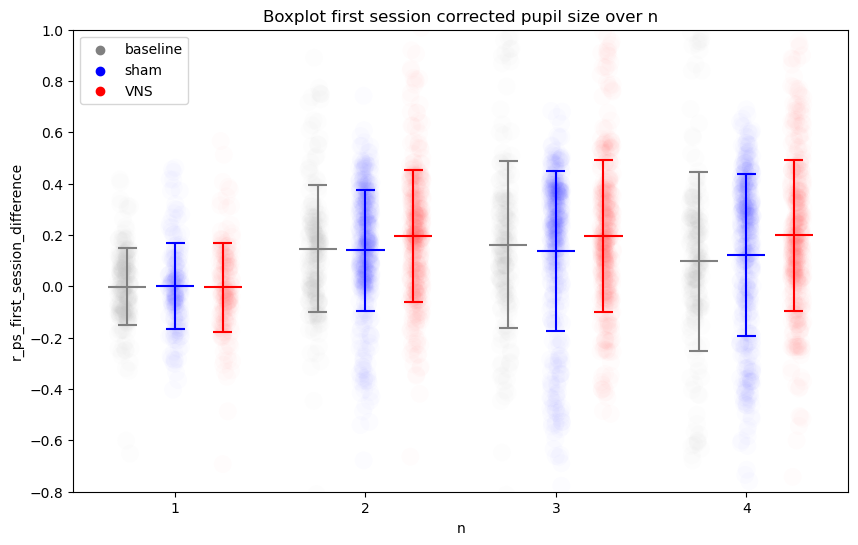

In [13]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def cohen_d(group1, group2):
    """
    Compute Cohen's d.
    
    Args:
        group1: Series or NumPy array
        group2: Series or NumPy array
    Returns:
        d (float): effect size
    """
    diff = np.mean(group1) - np.mean(group2)
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_var = ((n1-1) * var1 + (n2-1) * var2) / (n1 + n2 - 2)
    d = diff / np.sqrt(pooled_var)
    
    return d

def permutation_test(group1, group2, n_permutations=1000):
    """
    Perform a permutation test to compare means between two groups.

    Args:
        group1: Series or NumPy array for first group
        group2: Series or NumPy array for second group
        n_permutations: number of permutations to perform

    Returns:
        p-value
    """
    observed_diff = np.mean(group1) - np.mean(group2)
    combined = np.concatenate([group1, group2])
    perm_diffs = []

    for _ in range(n_permutations):
        perm_combined = np.random.permutation(combined)
        perm_group1 = perm_combined[:len(group1)]
        perm_group2 = perm_combined[len(group1):]
        perm_diff = np.mean(perm_group1) - np.mean(perm_group2)
        perm_diffs.append(perm_diff)

    p_value = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) / n_permutations
    return p_value

import os
import scipy
import numpy as np
import pandas as pd
sfreq = 30
sampling_interval = 5 * sfreq  
palette = {'sham': 'b', 'VNS': 'r', 'baseline': 'black'}

filename = 'temporal_et_sum.mat'
mat_file = scipy.io.loadmat(filename)
temporal_et_mat = mat_file['temporal_et_struct']

temporal_et_list = []
fields_of_interest = ['subj_id', 'study_id', 'session', 'event', 'time', 'r_ps', 'r_ps_z', 'r_ps_0_1']

for i in range(temporal_et_mat.shape[1]):  
    element = temporal_et_mat[0, i]
    element_dict = {}
    for field in fields_of_interest:  
        if (field == 'event') & (len(np.shape(element['event'])) == 2):
            element_dict[field] = element[field][0][0]
        elif (field == 'r_ps') or (field == 'r_ps_z')  or (field == 'r_ps_0_1'):
            element_dict[field] = element[field][:, 0]
        else:
            element_dict[field] = element[field][0]
    temporal_et_list.append(element_dict) 

df_et = pd.DataFrame(temporal_et_list)

def is_specific_event(value):
    return value in [1, 2, 3, 4]

df_et_1_4 = df_et[df_et['event'].apply(is_specific_event)]
r_ps_first_session_difference_list = []
r_ps_first_session_z_list = []

r_ps_resample_list = []
study_id_list = []
session_list = []
n_list = []

for index, row in df_et_1_4.iterrows():
    study_id_this_row = row['study_id']
    session_this_row = row['session']

    reference_r_ps = df_et_1_4[
        (df_et_1_4['event'] == 1) & 
        (df_et_1_4['study_id'] == study_id_this_row) & 
        (df_et_1_4['session'] == session_this_row)
    ]['r_ps'].explode().values.astype(float)

    if len(reference_r_ps) == 0 or np.all(np.isnan(reference_r_ps)):
        pass

    else:
        reference_r_ps = np.interp(np.arange(len(reference_r_ps)), np.flatnonzero(~np.isnan(reference_r_ps)), reference_r_ps[~np.isnan(reference_r_ps)])

        reference_r_ps = butter_lowpass_filter(reference_r_ps, cutoff_freq=0.1, sampling_rate=sfreq) 
        reference_mean_r_ps = np.nanmean(reference_r_ps)
        reference_std_r_ps = np.nanstd(reference_r_ps)
        
        if np.isnan(row['r_ps']).all():
            pass

        else:
            r_ps_value = row['r_ps']

            r_ps_value = np.interp(
                np.arange(len(r_ps_value)),
                np.flatnonzero(~np.isnan(r_ps_value)),
                r_ps_value[~np.isnan(r_ps_value)]
            )

            r_ps_filtered = butter_lowpass_filter(
                r_ps_value, cutoff_freq=0.1, sampling_rate=sfreq
            )
            
            r_ps_resampled = r_ps_filtered[::sampling_interval]
            
            for r_ps_value in r_ps_resampled:
                r_ps_resample_list.append(r_ps_value)
                r_ps_difference = r_ps_value - reference_mean_r_ps
                r_ps_first_session_difference_list.append(r_ps_difference)
                r_ps_z = (r_ps_value - reference_mean_r_ps) / reference_std_r_ps
                r_ps_first_session_z_list.append(r_ps_z)
                study_id_list.append(row['study_id'])
                session_list.append(row['session'])
                n_list.append(row['event'])
                


data = {
    'r_ps_resampled': r_ps_resample_list,
    'r_ps_first_session_difference': r_ps_first_session_difference_list,
    'r_ps_first_session_z': r_ps_first_session_z_list,
    'study_id': study_id_list,
    'session': session_list,
    'n': n_list
}

df_et_1_4 = pd.DataFrame(data)

df_et_1_4 = df_et_1_4.dropna(subset=['r_ps_first_session_difference'])
custom_palette = {'VNS': 'red', 'sham': 'blue', 'baseline': 'grey'}
hue_order = ['baseline', 'sham', 'VNS']
plt.figure(figsize=(10, 6))



sns.stripplot(x='n', y='r_ps_first_session_difference', hue='session', data=df_et_1_4, jitter=True, dodge=True, 
              marker='o', alpha=0.01, size=13, palette=custom_palette, hue_order=hue_order)

for i, n in enumerate([1, 2, 3, 4]):
    for j, session in enumerate(['baseline', 'sham', 'VNS']):
        session_data = df_et_1_4[(df_et_1_4['n'] == n) & (df_et_1_4['session'] == session)]
        mean_value = session_data['r_ps_first_session_difference'].mean()
        se_value = stats.sem(session_data['r_ps_first_session_difference'].dropna()) 
        std_value = np.std(session_data['r_ps_first_session_difference'].dropna())  
        
        x_position = i + (j - 1) * 0.25 
        
        plt.hlines(mean_value, xmin=x_position - 0.1, xmax=x_position + 0.1, color=custom_palette[session], linestyle='-')
        plt.hlines(mean_value + std_value, xmin=x_position - 0.05, xmax=x_position + 0.05, color=custom_palette[session], linestyle='-')
        plt.hlines(mean_value - std_value, xmin=x_position - 0.05, xmax=x_position + 0.05, color=custom_palette[session], linestyle='-')
        plt.vlines(x=x_position, ymin=mean_value - std_value, ymax=mean_value + std_value, color=custom_palette[session])

plt.ylim([-0.8, 1])
plt.legend(loc='best')
plt.title('Boxplot first session corrected pupil size over n')

plt.show()

